<a href="https://colab.research.google.com/github/Bryan-Az/Neurobytes/blob/notebooks/mlops/notebooks/users_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of the Synthetic User Preferences


## Spotify Million Song Dataset (Via Kaggle)
This synthetic dataset was generated with the Kaggle 'Spotify Million Song' dataset.

The original data contains the features:

- 'artist': The name of the artist
- 'song': The name of the song
- 'text': The song lyrics
- 'link': The link to the song via spotify api

A sample of 10,000 rows was selected from this dataset to calculate synthetic user preferences, as the original dataset is very large. The document-term matrix was calculated, where each song is a document and the words in the lyrics are the terms.

## Synthetic User Preference Data

The cosin similarity was calculated, representing the similarity between from songs-to-songs by their lyrics. This data was then used to calculate synthetic user data by sampling a 'starter' song for each user, and then using the top 3 similar songs to the original song as their sample user preferences. Then, the following two columns were added to a new user preferences dataset:

- 'songID': a many-to-one foreign key to the original song dataset.
- 'userID': a many-to-one userID index.

Our synthetic user prefernce generator selects n_starter songs and then uses cosin similarity to select n further top-n similar songs for the original n_starter song, such that each user will have a variety of 'tastees'.

 For example, each 'song cluster' sample (n_starter) includes self (original song) with similarity of 1, then included n similar songs (starter song + n similar songs).
  
  To calculate the size, for example, n = 3, songs_per_user = 50, num_users=1000
  returns: num_users * (n + 1) * (songs_per_user) = ~200,000 preferences (variable as n_starter is random value between 40-50).



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

In [61]:
! pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [73]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
users_glink = 'https://drive.google.com/file/d/1fw3kszKGlaz4x6oMgCMNmY_s3ejwdGxT/view?usp=drive_link'
filename = 'user_preferences.csv'

In [5]:
def get_link_content(link, name):
  file_id = link.split('/')[-2]
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

In [6]:
get_link_content(users_glink, filename)

In [7]:
user_preferences = pd.read_csv(filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [19]:
user_preferences.shape

(178340, 6)

# Identifying the 'Favorite'/'Most Listened' to Artist's

As the algorithm to generate synthetic user preferences assigned users clusters of songs that had fairly similar cosin similarity (at random, based on samples of the main dataset) using the lyric information, every user should have a different set of artists and a different ranking of artists by # songs within the user preferences dataset.

In [46]:
preference_size_distribution = user_preferences.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution

count    1000.000000
mean      178.340000
std        11.171804
min       160.000000
25%       168.000000
50%       180.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [113]:
sample_user = user_preferences.where(user_preferences['userID'] == user_preferences['userID'].sample(1).iloc[0]).dropna() # a sample user

In [114]:
sample_user.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
U2              4.0
Neil Young      4.0
Ace Of Base     4.0
Van Morrison    3.0
Z-Ro            3.0
Xzibit          3.0
Kanye West      3.0
Phish           3.0
Paul Simon      3.0
Faith Hill      2.0
dtype: float64

Given a sample user, it seems that identifying their 'favorite' artist would be a tough choice to make. The majority of artists within this sample user's preferences only make one or two appearances, and any artist with more than 3 appearances is very rare.

My theory is that given that 'artist' name was not used as input to the cosin similarity algorithm, it could be ignoring the artist's identities when making recommendations, and user preferences do not seem to skew to any particular artist.

<Axes: >

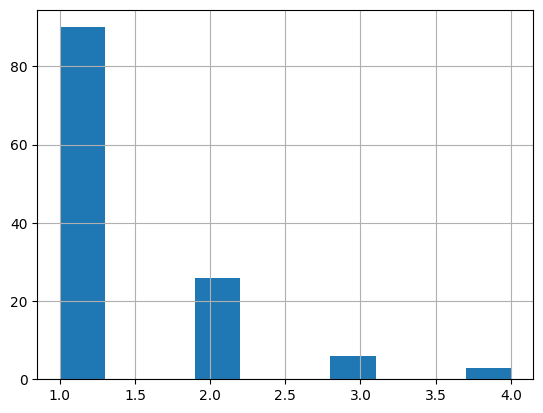

In [115]:
# plotting the distribution of artist count for the sample user
sample_user.groupby('artist').count().mean(axis=1).hist(bins=10)

By visualizing the same distribution - this time using the entire user preferences dataset - we can see that most artists make an appearance within a user's library 1-3 times, with a small right tail skewing the distribution towards 4-8 appearances.

Perhaps including the artist's name or the album name into the document-term matrix before generating the synthetic user preferences would allow for a more concentrated selection of choices that might mimic how individual user's tend to favor entire albums or playlists centered around a particular artist.

<Axes: >

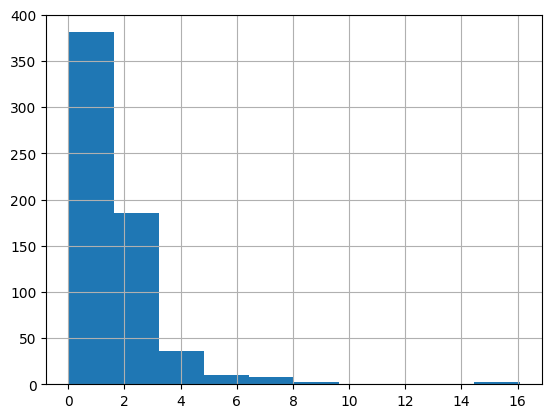

In [116]:
# plotting similar distribution using the entire dataset
(user_preferences.groupby('artist').count() / preference_size_distribution['mean']).mean(axis=1).hist(bins=10)

Including the entire lyrics dataset along with the artist name will bias the similarity calculation, so instead, only the top 5 most frequent words in the lyrics will be included, to allow for artist name to be given a higher weight.

In [117]:
user_preferences['artist'].apply(lambda x: len(x.split(' '))).mean() # artist name tends to have 1-2 words

1.8051082202534485

In [118]:
user_preferences['text'].apply(lambda x: len(x.split(' '))).mean() # lyrics tend to have 337! words

337.1851575642032

In [119]:
# lets make a function to select only the top n words in the lyrics
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
def top_n_words(text, n):
  freq_dist = FreqDist(word_tokenize(text))
  # remove filler words
  freq_dist = FreqDist({key: val for key, val in freq_dist.items() if key not in nltk.corpus.stopwords.words('english')})
  # select only the words from the (word, freq) tuple list
  words = ' '.join([word for word, freq in freq_dist.most_common()])
  return words

In [120]:
top_words = sample_user['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [121]:
top_words.iloc[0] # concatenates the top 5 words for each of the songs in the user's preferences

"I 'm outsider outside everything Everything know It disturbs Everybody tried push put All 've already fun around try messed , hey everyone troubles gon na come"

In [122]:
# visualization of the sample users top_n words using a word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white')

In [130]:
sample_user_artists = ' '.join(sample_user['artist'].tolist())
sample_user_artists

"Ramones Supertramp Snoop Dogg Michael W. Smith Zoegirl Tina Turner Reba Mcentire Christina Aguilera Judy Garland 'n Sync Olivia Newton-John Who Puff Daddy Chaka Khan Keith Urban Steve Miller Band Prince John Waite Pet Shop Boys Ozzy Osbourne Xzibit Lou Reed Lionel Richie Iron Maiden Utopia Insane Clown Posse Z-Ro Dusty Springfield Young Dro Fun. Youngbloodz J Cole Megadeth Nickelback Hillsong United Howard Jones Cliff Richard Cliff Richard Dan Fogelberg Z-Ro Dan Fogelberg Gary Valenciano John Denver Imagine Dragons Phish Clash Marillion Sting Bruno Mars Kanye West Insane Clown Posse John Martyn Justin Timberlake Neil Diamond Engelbert Humperdinck Billie Holiday Deep Purple Deep Purple Arlo Guthrie Neil Young Yelawolf Barbra Streisand Marillion Matt Redman Mariah Carey Josh Groban Leonard Cohen Jimi Hendrix Ocean Colour Scene Ace Of Base Ace Of Base Nicki Minaj Bob Dylan Rush U2 U2 Xzibit Nightwish Michael W. Smith Evanescence Erasure Gary Numan Gary Numan U2 Queen Latifah Kanye West A

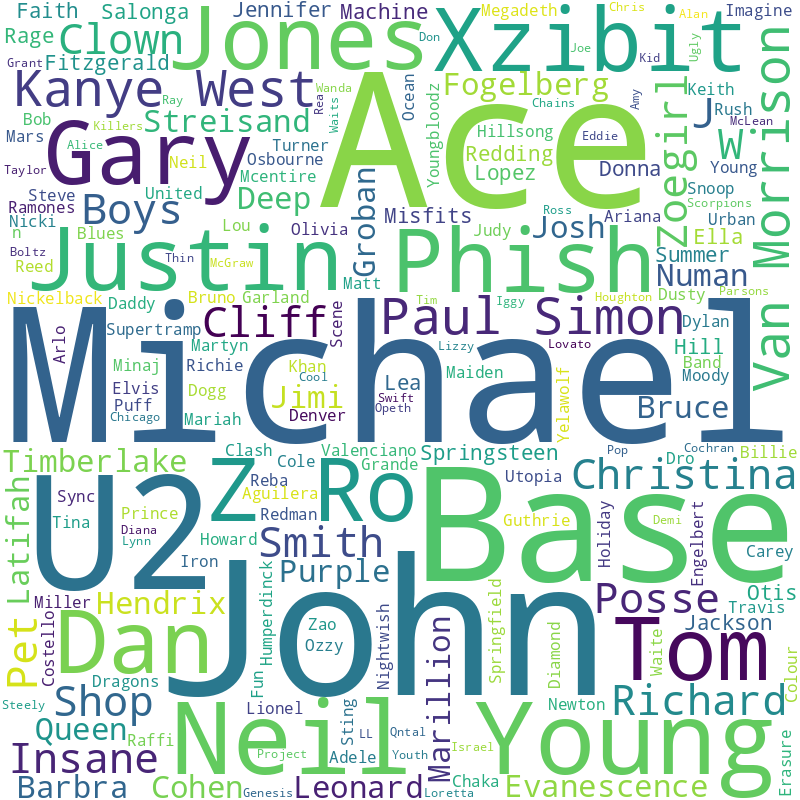

In [131]:
wordcloud.generate(sample_user_artists).to_image() # word cloud of sample users artist preferences

In [132]:
sample_user_words = ' '.join(top_words.tolist())
sample_user_words

"I 'm outsider outside everything Everything know It disturbs Everybody tried push put All 've already fun around try messed , hey everyone troubles gon na come 're n't And , 's gon na know ' got Hey brother move better ? tell get I They We ta Ai us bound good Try If see But one make feel tellin Is thing walk Then like Do sow soul around way place inside let gettin There red cloud hanging big burst All people heads ground everywhere care hear sound lie real next That deal message giving old alibi quite point view treat spy phone rings disappear In middle night Ca trying prove sit oh cool Like never broke rules cat flies crow walks ghost dies talks 'll gold Be ... 'lieve nothing told Make direction compromise greet rejection Makin lies turn Better sky For sake holy Listen say could day act Why look clear away 've leave It hopeless case else blame lose game back track hatred deep take alive 'm burn wait Boy ai heart mind weak blood runnin cold You hide caught reap fool go safe stay , ! I

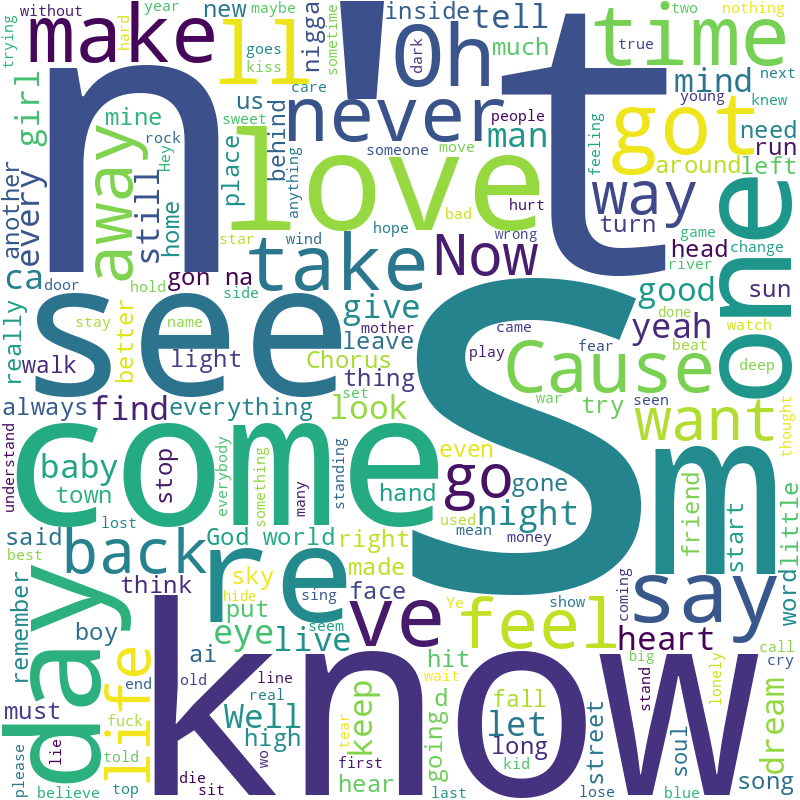

In [133]:
wordcloud.generate(sample_user_words).to_image() # word cloud of sample user's lyric preferences